<center>
<img src="https://drive.google.com/uc?id=1cwPX7BgVIwtG7Rpd9FQGdfOxaVrgaR59" alt="Descripción" width="178">

<img src="https://drive.google.com/uc?id=1bLJqVtTvaYSS46sJ_VSVmY7j8QgfhAln" alt="Descripción" width="100">
</center>

---
# **Bioinformática 2025**

---

# Bioinformática 2025 - TP Nº2: Biopython

El objetivo general de esta práctica es trabajar con diferentes funciones “útiles” asociadas al manejo de secuencias biológicas.

## Objetivo 4: Mis primeros programas bioinformáticos y análisis de secuencias avanzado. Para entregar en el informe.

Ahora combinaremos todo lo aprendido anteriormente para realizar nuestro primer programa bioinformático que consiste en un detector de ORFs a partir de una secuencia de ADN (que podría provenir de un genoma). Como cualquier programa complejo, el mismo va utilizar diferentes módulos y además requerirá combinar código de diferentes miembros del grupo, el objetivo entonces es:
i) organizar un programa complejo en módulos de código, y
ii) trabajar en equipo.

Para facilitar esta tarea, el ejercicio 4 está dividido en módulos/secciones.

===> Como grupo traten primero de organizar el código general y luego repartan y organicen cada módulo.


### Ejercicio 4) Comparación de distribuciones

#### Funciones utilizadas para generar secuencias artificiales y analizarlas

In [6]:
import random 

def generar_secuencia_random(l,mode):   #el modo indica si se busca generar secuencias de ADN o aminoácidos
    aminoacidos = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    nucleotidos = ['A','T','C','G']
    # Generar una secuencia aleatoria con aminoácidos seleccionados uniformemente
    secuencia= ""
    for i in range(l):
        if mode == 'dna':
          valor = random.choice(nucleotidos)
        elif mode == 'protein':
          valor = random.choice(aminoacidos)
        secuencia += valor
    return secuencia

def obtener_frecuencia_aa(sec):
  aminoacidos = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
  frecuencias = {aa: sec.count(aa)/len(sec) for aa in aminoacidos}
  return frecuencias

def traducir_secuencia(sec): # Suponiendo que nos encontramos dentro del ORF y alineados correctamente dentro del frame
    ss_dict = {               # Se arma un diccionario de código genético
      'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
      'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
      'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
      'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
      'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
      'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
      'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
      'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
      'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
      'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
      'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
      'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
      'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
      'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
      'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
      'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',
    }
    prot_sec = ''
    for i in range (len(sec)-2):
        prot_sec += ss_dict[sec[i:i+3]]
    return prot_sec

#### Funciones utilizadas para obtener secuencias de proteínas reales y analizarlas

In [108]:
import requests
import matplotlib.pyplot as plt

# Esta función descarga 10 proteínas humanas (organism_id:9606) al azar y las mete dentro de un archivo proteinas.fasta
def descargar_proteinas_azar(cantidad=10, nombre_archivo="proteinas.fasta"):

    # Paso 1: Obtener una lista de muchos IDs (ej: 500 proteínas humanas revisadas)
    url_ids = "https://rest.uniprot.org/uniprotkb/search"
    query = "organism_id:9606 AND reviewed:true"
    params_ids = {
        "query": query,
        "format": "json",
        "fields": "accession",
        "size": 500
    }

    response_ids = requests.get(url_ids, params=params_ids)

    if response_ids.status_code != 200:
        print("Error al obtener IDs:", response_ids.status_code, response_ids.text)
        return

    resultados = response_ids.json().get("results", [])
    ids = [entry["primaryAccession"] for entry in resultados]
    
    if len(ids) < cantidad:
        print(f"Solo se encontraron {len(ids)} proteínas.")
        cantidad = len(ids)

    ids_seleccionados = random.sample(ids, cantidad)

    # Paso 2: Descargar FASTA para cada ID
    fasta_data = ""
    for acc in ids_seleccionados:
        fasta_url = f"https://rest.uniprot.org/uniprotkb/{acc}.fasta"
        r = requests.get(fasta_url)
        if r.status_code == 200:
            fasta_data += r.text
        else:
            print(f"No se pudo obtener {acc}")

    # Paso 3: Guardar archivo FASTA
    with open(str(cantidad)+'_'+nombre_archivo, "w") as f:
        f.write(fasta_data)

    print(f"{cantidad} proteínas guardadas")

# Esta función abre un archivo fasta y devuelve el tamaño promedio de las secuencias en él
def tamaño_promedio_proteinas(fasta_path):
    # Abre el archivo fasta en modo lectura
    with open(fasta_path, "r") as f:
        lineas = f.readlines()  # Lee todas las líneas del archivo

    secuencias = []     # Lista para almacenar las secuencias completas
    sec_actual = ""     # Variable temporal para construir cada secuencia

    # Recorre todas las líneas del archivo
    for linea in lineas:
        if linea.startswith(">"):
            # Si se encuentra un encabezado, guarda la secuencia actual si existe
            if sec_actual:
                secuencias.append(sec_actual)
                sec_actual = ""
        else:
            # Si no es encabezado, agrega la línea (sin saltos de línea) a la secuencia actual
            sec_actual += linea.strip()

    # Agrega la última secuencia si quedó sin guardar
    if sec_actual:
        secuencias.append(sec_actual)

    # Si no hay secuencias, devuelve 0
    if not secuencias:
        return 0

    # Calcula las longitudes de todas las secuencias
    longitudes = [len(sec) for sec in secuencias]

    # Calcula el promedio de longitudes
    promedio = sum(longitudes) / len(longitudes)

    return round(promedio, 2)  # Redondea el resultado a dos decimales


# Esta función abre un archivo fasta y devuelve la frecuencia relativa de cada aminoácido para las primeras n secuencias
def frecuencia_promedio_aminoacidos(fasta_path, n=1000):
    # Abre el archivo fasta y lee todas las líneas
    with open(fasta_path, "r") as f:
        lineas = f.readlines()

    secuencias = []     # Lista para guardar las secuencias
    sec_actual = ""     # Variable temporal para construir una secuencia

    # Recorre cada línea del archivo
    for linea in lineas:
        if linea.startswith(">"):
            # Si se encuentra un encabezado, guarda la secuencia actual si existe
            if sec_actual:
                secuencias.append(sec_actual)
                sec_actual = ""
            # Detiene el bucle si ya se tienen las n secuencias necesarias
            if len(secuencias) == n:
                break
        elif len(secuencias) < n:
            # Agrega la línea a la secuencia actual (elimina saltos de línea)
            sec_actual += linea.strip()

    # Asegura que se agregue la última secuencia si quedó sin guardar
    if sec_actual and len(secuencias) < n:
        secuencias.append(sec_actual)

    # Si no se encontraron secuencias, retorna diccionario vacío
    if not secuencias:
        return {}

    suma_frecuencias = {}  # Diccionario para acumular las frecuencias

    # Calcula la frecuencia relativa de cada aminoácido en cada secuencia
    for sec in secuencias:
        frec = obtener_frecuencia_aa(sec)
        for aa in frec:
            if aa in suma_frecuencias:
                suma_frecuencias[aa] += frec[aa]
            else:
                suma_frecuencias[aa] = frec[aa]

    # Calcula el promedio dividiendo la suma por la cantidad de secuencias
    promedio_frecuencias = {
        aa: round(suma_frecuencias[aa] / len(secuencias), 4)
        for aa in suma_frecuencias
    }

    return promedio_frecuencias


# La siguiente linea tarda unos minutos
#descargar_proteinas_azar(100)


#### a) Compare Distribución de aminoácidos de secuencia de proteínas al azar vs. secuencias de proteínas reales.




Tamaño promedio: 509.72


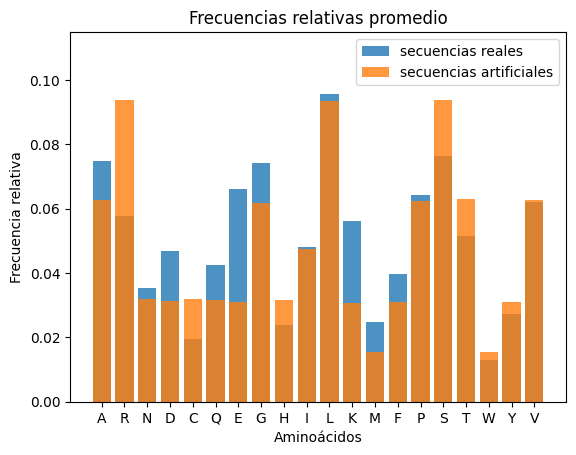

In [51]:
n = 100

# Tomo las primeras n proteínas del archivo fasta y calculo el promedio de la frecuencia de cada aminoácido
frecuencias_reales = frecuencia_promedio_aminoacidos("100_proteinas.fasta", n)
tamaño_proteina_promedio = tamaño_promedio_proteinas("100_proteinas.fasta")
print(f'Tamaño promedio: {tamaño_proteina_promedio}')

# Genero una secuencia artificial de ADN para traducir y analizar. En vez de generar n secuencias de tamaño_proteina_promedio*3 nucleótidos, genero solo 1 de n*tamaño_proteina_promedio*3
secuencia_artificial = generar_secuencia_random(n*int(tamaño_proteina_promedio)*3,'dna')
# Traduzco la secuencia artificial de ADN a proteína
secuencia_artificial_traducida = traducir_secuencia(secuencia_artificial)
# Obtengo la frecuencia de cada aminoácido en la proteína artificial
frecuencias_artificiales = obtener_frecuencia_aa(secuencia_artificial_traducida)


# Hago un gráfico de barras con las frecuencias obtenidas para ambos casos
aas = list(frecuencias_reales.keys())
freq_real = list(frecuencias_reales.values())
freq_art = list(frecuencias_artificiales.values())

plt.bar(aas, freq_real, alpha=0.8, label="secuencias reales")
plt.bar(aas, freq_art, alpha=0.8, label="secuencias artificiales")  # distinta opacidad para distinguir

plt.title("Frecuencias relativas promedio")
plt.xlabel("Aminoácidos")
plt.ylabel("Frecuencia relativa")
plt.ylim(0, max(freq_real + freq_art) * 1.2)  # Ajuste visual
plt.legend()
plt.show()

Como se puede ver, las frecuencias de aminoácidos de las secuencias reales difieren de las secuencias generadas a partir de la traducción de secuencias artificiales de nucleótidos. Sin embargo, son mucho más similares aquellas obtenidas suponiendo igual equiprobabilidad para cada aminoácido.

#### b) Analice cómo cambian las distribuciones al aumentar el tamaño de la secuencia “al azar” analizada, y al incrementar el número de secuencias reales analizadas. ¿Cuándo es suficiente?

***Ayuda***: seaborn.histplot() o matplotlib.pyplot.hist() pueden ayudar con las comparaciones

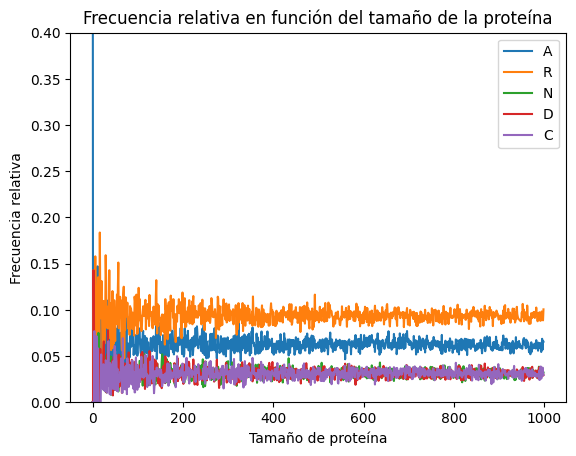

In [75]:
n_min = 1
n_max = 1000

# Inicializo el diccionario para que contenga todos los aa
frecuencias_vs_tamaño = obtener_frecuencia_aa(' ')
# Convierto cada valor del diccionario en una lista vacía
for aa in frecuencias_vs_tamaño:
    frecuencias_vs_tamaño[aa] = []


# A cada lista correspondiente a un aa, agrego la frecuencia de cada aminoácido al generar una proteína de tamaño i*3
for i in range (n_min, n_max):
    secuencia_artificial = generar_secuencia_random(i*3,'dna')
    secuencia_artificial_traducida = traducir_secuencia(secuencia_artificial)
    frecuencias_artificiales = obtener_frecuencia_aa(secuencia_artificial_traducida)
    for aa in frecuencias_vs_tamaño:
        frecuencias_vs_tamaño[aa].append(frecuencias_artificiales[aa])

# Grafico los n primeros aa en el diccionario en función del tamaño de la secuencia
n = 5 
for i,aa in enumerate(frecuencias_vs_tamaño):
    plt.plot(frecuencias_vs_tamaño[aa], label=f'{aa}')
    if i == n-1: 
        break

plt.title("Frecuencia relativa en función del tamaño de la proteína")
plt.xlabel("Tamaño de proteína")
plt.ylabel("Frecuencia relativa")
plt.legend()
plt.ylim(0,0.4)
plt.show()

Se comparó la frecuencia para 5 aminoácidos en proteínas aleatorias de distinto tamaño. Como se puede ver, a tamaños bajos, la varianza es grande; Pero a medida que el tamaño aumenta, las frecuencias tienden a estabilizarse en un valor. Este valor se puede calcular teniendo en cuenta la cantidad de codones que lo codifican y la frecuencia de cada codón en una secuencia aleatoria de nucleótidos.
Si se quiere un valor umbral para el cual el tamaño sea suficiente, puede considerarse el error estándar de una población de proteínas de un tamaño determinado respecto a la frecuencia de un aminoácido. Si el error estándar es menor a 0.05 por ejemplo, podría considerarse suficiente.

Habrá notado que en los ejercicios anteriores sería muy útil tener una métrica  (programada) que permita comparar distribuciones. Existen numerosas métricas estadísticas que permiten comparar distribuciones (i,e chi cuadrado),  una muy simple es determinar la diferencia cuadrática media de cada uno de los “bins” del histograma de la distribución.

#### c ): Elija una métrica que permita comparar dos distribuciones. (p.ej., chi-cuadrado, MSE). 



In [ ]:
#Calcula la raíz del el error cuadrático medio para dos diccionarios de frecuencias 
def calcular_rmse(freqs1, freqs2):
    # Inicializa suma de errores al cuadrado
    suma_errores_cuadrado = 0
    n = len(freqs1)  # Número de elementos

    for clave in freqs1:
        # Calcula el error cuadrático entre los valores
        diferencia = freqs1[clave] - freqs2[clave]
        suma_errores_cuadrado += diferencia ** 2

    # Calcula la raíz cuadrada usando potencia 0.5
    rmse = (suma_errores_cuadrado / n) ** 0.5
    return rmse

# Hago lo mismo que en a) pero para distintas cantidades de secuencias

n_max = 50

for i in range(1, n_max, 10):

    frecuencias_reales = frecuencia_promedio_aminoacidos("100_proteinas.fasta", i)
    tamaño_proteina_promedio = tamaño_promedio_proteinas("100_proteinas.fasta")

    secuencia_artificial = generar_secuencia_random(i*int(tamaño_proteina_promedio)*3,'dna')
    secuencia_artificial_traducida = traducir_secuencia(secuencia_artificial)
    frecuencias_artificiales = obtener_frecuencia_aa(secuencia_artificial_traducida)

    RMSE = calcular_rmse(frecuencias_reales, frecuencias_artificiales)

    print(f'Cantidad de secuencias: {i}')
    print(f'RMSE: {RMSE:.3f}\n')


Cantidad de secuencias: 1
RMSE: 0.021

Cantidad de secuencias: 11
RMSE: 0.016

Cantidad de secuencias: 21
RMSE: 0.015

Cantidad de secuencias: 31
RMSE: 0.015

Cantidad de secuencias: 41
RMSE: 0.015



Parece que la raíz del el error cuadrático medio tiende a 0.015. Quizás este valor cambie si se tiene en cuenta otro conjunto de proteínas reales

#### d): Escriba un código que dadas dos distribuciones las compare y obtenga la métrica correspondiente. Utilicela para:

***i:** ver como evoluciona las distribuciones obtenidas en 4a(i) al aumentar el tamaño de la muestra.

**ii:** estudiar de manera sistemática las diferencias entre las distribuciones obtenidas en 4a para diferentes muestras.


C:\Users\H_Gar\AppData\Local\Temp\ipykernel_3668\3522658229.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


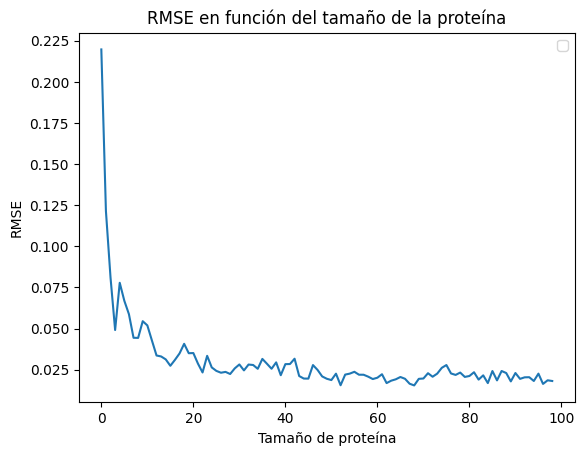

In [74]:
frecuencias_reales = frecuencia_promedio_aminoacidos("100_proteinas.fasta", 100)

n_min = 1
n_max = 100

RMSEs = []
for i in range (n_min, n_max):
    # Genere una frecuencia artificial al igual que en los puntos anteriores
    secuencia_artificial = generar_secuencia_random(i*3,'dna')
    secuencia_artificial_traducida = traducir_secuencia(secuencia_artificial)
    frecuencias_artificiales = obtener_frecuencia_aa(secuencia_artificial_traducida)
    # Calculo el RMSE comparando las frecuencias reales con las artificiales y lo agrego a la lista RMSEs
    RMSEs.append(calcular_rmse(frecuencias_reales, frecuencias_artificiales))


plt.plot(RMSEs)
plt.title("RMSE en función del tamaño de la proteína")
plt.xlabel("Tamaño de proteína")
plt.ylabel("RMSE")
plt.legend()
#plt.ylim(0,0.4)
plt.show()

La raíz del error cuadrático medio disminuye a medida que aumenta el tamaño de la proteína. Esto tiene sentido, ya que cuanto mayor es el tamaño de la muestra, menor es el desvío estándar y más probable es que el promedio de una variable sea similar al de la media poblacional.

#### e) Detector de ORFs

Con todo lo aprendido anteriormente escriba un código que:

**i:** levante una secuencia de ADN

**ii:** Obtenga los 6 marcos de lectura posibles y determine los ORFs de cada uno de ellos.

**iii:** Para cada ORF determine a) la longitud del mismo y b) la distribución de aminoácidos.

**iv:** En base a lo analizado previamente determine a partir del largo y la distribución una probabilidad de corresponder (o no) a una región codificante.

**v:** Para probar su programa diseñe: a) un control positivo b) un control negativo, luego obtenga de alguna base de datos de secuencias genómicas la secuencia de un gen eucariota completo y corra su programa. Compare sus resultados con lo esperado.
¿Qué modificaciones podría agregar para mejorar su capacidad predictiva?


In [138]:
from Bio.Seq import Seq
import re
from Bio import SeqIO
import statistics
from scipy.stats import norm


def obtener_orfs(seq):
    bio_sec = Seq(seq)
    complemento_reverso = bio_sec.reverse_complement()
    print(complemento_reverso)
    orfs = []
    
    # Busco ORFs utilizando el patrón de codón de inicio (ATG) y codones stop (TAA, TGA, TAG)
    for match in re.finditer(r'ATG(?:...)*?(TAA|TAG|TGA)', str(bio_sec)):
        orf = seq[match.start():match.end()]
        
        # Verifico que el tamaño del posible orf sea múltiplo de 3
        if len(orf) % 3 == 0:
            orfs.append(Seq(orf))

    # Busco ORFs en el complemento reverso
    for match in re.finditer(r'ATG(?:...)*?(TAA|TAG|TGA)', str(complemento_reverso)):
        orf = seq[match.start():match.end()]
        
        if len(orf) % 3 == 0:
            orfs.append(Seq(orf))
    
    return orfs

def obtener_largo_y_frecuencias(seq):
    orfs = obtener_orfs(seq)
    tamaños_orfs = []
    frecuencias_orfs = []

    for orf in orfs:
        tamaños_orfs.append(len(orf))
        traduccion = orf.translate()
        frecuencias = obtener_frecuencia_aa(traduccion)
        frecuencias_orfs.append(frecuencias)

    return tamaños_orfs, frecuencias_orfs


# Comparo la longitud de una secuencia con el promedio de proteínas reales, considerando el desvío estándar
def probabilidad_por_longitud(longitud_secuencia, media, desviacion_std):
    z_score = (longitud_secuencia - media) / desviacion_std
    return norm.pdf(z_score)  # Densidad de probabilidad

# Función que devuelve el desvío estándar de la longitud de las secuencias en un multifasta
def sd_protein_lengths(multifasta_path):

    # Parseamos todas las secuencias y calculamos sus longitudes
    lengths = [len(record.seq) for record in SeqIO.parse(multifasta_path, "fasta")]

    # Si tenemos menos de dos longitudes, la stdev no está definida (devolvemos 0.0)
    if len(lengths) < 2:
        return 0.0

    # statistics.stdev calcula el desvío estándar de la muestra
    return statistics.stdev(lengths)

def probabilidad_proteina_verdadera(fasta_proteinas_reales, secuencia_proteina_prueba):
    # Calcula frecuencias y longitudes de proteínas reales
    frecuencias_reales = frecuencia_promedio_aminoacidos(fasta_proteinas_reales)
    media_longitud = tamaño_promedio_proteinas(fasta_proteinas_reales)  # Nueva función
    std_longitud = sd_protein_lengths(fasta_proteinas_reales)
    
    # Características de la secuencia de prueba
    frecuencias_prueba = obtener_frecuencia_aa(secuencia_proteina_prueba)
    longitud_prueba = len(secuencia_proteina_prueba)
    rmse = calcular_rmse(frecuencias_reales, frecuencias_prueba)
    
    # Likelihood bajo modelo real
    likelihood_real = 1 / (1 + rmse)  # Relación inversa con RMSE
    likelihood_real *= probabilidad_por_longitud(longitud_prueba, media_longitud, std_longitud)
    
    # Likelihood bajo modelo nulo
    # Frecuencias esperadas en no codificantes (ejemplo simplificado)
    frecuencias_nulo = {aa: 1/20 for aa in frecuencias_reales}
    rmse_nulo = calcular_rmse(frecuencias_nulo, frecuencias_prueba)
    likelihood_nulo = 1 / (1 + rmse_nulo)
    
    # Probabilidad Bayesiana (asumiendo priors 50%-50%)
    return float(likelihood_real / (likelihood_real + likelihood_nulo))

# Control negativo
seq = generar_secuencia_random(1000,'protein')
p = probabilidad_proteina_verdadera("100_proteinas.fasta",seq)
print('Control positivo:')
print(p)
print('\n')

# Control positivo
# >sp|O75629|CREG1_HUMAN Protein CREG1 OS=Homo sapiens OX=9606 GN=CREG1 PE=1 SV=1
seq = "MAGLSRGSARALLAALLASTLLALLVSPARGRGGRDHGDWDEASRLPPLPPREDAARVARFVTHVSDWGALATISTLEAVRGRPFADVLSLSDGPPGAGSGVPYFYLSPLQLSVSNLQENPYATLTMTLAQTNFCKKHGFDPQSPLCVHIMLSGTVTKVNETEMDIAKHSLFIRHPEMKTWPSSHNWFFAKLNITNIWVLDYFGGPKIVTPEEYYNVTVQ"
p = probabilidad_proteina_verdadera("100_proteinas.fasta",seq)
print('Control negativo:')
print(p)

# No funciona muy bien. Para mejorar su capacidad predictiva, podrían considerarse 
# otros aspectos. Podróia realizarse por ejemplo un test chi-cuadrado de bondad de 
# ajuste para las frecuencias absolutas de aminoácidos.

Control positivo:
0.15883731729972014


Control negativo:
0.2387190757165575


# Material de referencia

Tutorial de Biopython: https://biopython.org/wiki/Documentation
Documentación de SeqIO: https://biopython.org/wiki/SeqIO
Base de datos de UniProt: https://www.uniprot.org/
Base de datos GenBank: https://www.ncbi.nlm.nih.gov/genbank/
